In [1]:
import os
import xarray as xr
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import groupby
from toolz import partition
from glob import glob

/N/u/amulla/Quartz/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
%cd /N/project/Zli_lab/ERA5_land_data
curr_data_path = os.getcwd()
curr_data_path

/N/project/Zli_lab/ERA5_land_data


'/N/project/Zli_lab/ERA5_land_data'

In [3]:
def read_data(s_dir, month, year):
    path = os.path.join(s_dir, f"Hourly_Total_Precipitation_T_{str(month).zfill(2)}{year}.nc")
    ds = xr.open_dataset(path)
    return ds

In [4]:
def save_indice(filename, data_var):
    folder = '../indices/seasonal'
    data_var.to_netcdf(f'{folder}/{filename}.nc')
    print(f"{filename}_File Saved")

In [5]:
def date_range(year,start_month,end_month):
    start_date = np.datetime64(f'{year}-{str(start_month).zfill(2)}-01') if start_month < 12 else np.datetime64(f'{year-1}-12-01')
    end_date = np.datetime64(f'{year}-{str(end_month+1).zfill(2)}-01')
    date_range = np.arange(start_date, end_date, dtype='datetime64[h]')
    formatted_date_range = date_range.astype('datetime64[ns]')
    return formatted_date_range

In [6]:
def DiCyc1mm(data):
    wet_day_thresh = 1/1000       # 1mm to meter
    nan_mask = np.isnan(data)
    binary_mask = np.where(nan_mask, 0, 1)
    numeric_indices = np.where(binary_mask == 1)[0]
    if len(numeric_indices) == 0:
        maxima_data = [np.nan] * 24
        maxima_data = np.stack(maxima_data,axis=-1)
        return maxima_data
    elif len(numeric_indices) == len(data):
        p_list = list(partition(24, data))
        total_prep = np.sum(p_list,axis=1)
        cwd = np.count_nonzero(total_prep>(1/1000)) # counts number of true values
        if cwd>0:
            wet_days_prep_values = np.array(p_list)[total_prep>(1/1000)]
            total_24_hour_prep = np.sum(np.array(wet_days_prep_values),axis=0)
            maxima_data = total_24_hour_prep / cwd
            maxima_data = np.stack(maxima_data,axis=-1)
            return maxima_data
        else:
            maxima_data = [0] * 24
            maxima_data = np.stack(maxima_data,axis=-1)
            return maxima_data
    elif len(numeric_indices) > 0 and len(numeric_indices) < len(data):
        nan_indices = np.where(binary_mask == 0)[0]
        data = data.copy()
        data[nan_indices] = 0
        p_list = list(partition(24, data))
        total_prep = np.sum(p_list,axis=1)
        cwd = np.count_nonzero(total_prep>(1/1000))
        wet_days_prep_values = np.array(p_list)[total_prep>(1/1000)]
        total_24_hour_prep = np.sum(np.array(wet_days_prep_values),axis=0)
        maxima_data =  total_24_hour_prep / cwd
        maxima_data = np.stack(maxima_data,axis=-1)
        return maxima_data

In [7]:
def calc_ind(data,indice):
    ind_arr = []
    seasons = {'MAM':[3, 4, 5], 'JJA':[6, 7, 8], 'SON':[9, 10, 11], 'DJF':[12, 1, 2]}
    for season, months in seasons.items():
        print("Season : ", season)
        selected_data = data.sel(time=data['time.month'].isin(months))
        result_indice = xr.apply_ufunc(indice, selected_data, input_core_dims=[['time']],
        output_core_dims=[['hour']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[np.float64],)
        ind_arr.append(result_indice)
    return ind_arr

In [8]:
MAM_data = []
JJA_data = []
SON_data = []
DJF_data = []
for year in range(1979,2024):
    yearly_data = []
    for month in range(1, 12):
        ds = read_data(curr_data_path, month, year)
        if 'expver' in ds.dims:
            ds = ds.sel(expver=1).combine_first(ds.sel(expver=5))
            yearly_data.append(ds)
        else:
            yearly_data.append(ds)
    yearly_data.append(read_data(curr_data_path, 12, year-1))
    combined_data = xr.concat(yearly_data, dim="time")
    result = calc_ind(combined_data, DiCyc1mm)
    MAM_data.append(result[0])
    JJA_data.append(result[1])
    SON_data.append(result[2])
    DJF_data.append(result[3])
    print(year)

Season :  MAM
Season :  JJA
Season :  SON
Season :  DJF
1979
Season :  MAM
Season :  JJA
Season :  SON
Season :  DJF
1980
Season :  MAM
Season :  JJA
Season :  SON
Season :  DJF
1981
Season :  MAM
Season :  JJA
Season :  SON
Season :  DJF
1982
Season :  MAM
Season :  JJA
Season :  SON
Season :  DJF
1983
Season :  MAM
Season :  JJA
Season :  SON
Season :  DJF
1984
Season :  MAM
Season :  JJA
Season :  SON
Season :  DJF
1985
Season :  MAM
Season :  JJA
Season :  SON
Season :  DJF
1986
Season :  MAM
Season :  JJA
Season :  SON
Season :  DJF
1987
Season :  MAM
Season :  JJA
Season :  SON
Season :  DJF
1988
Season :  MAM
Season :  JJA
Season :  SON
Season :  DJF
1989
Season :  MAM
Season :  JJA
Season :  SON
Season :  DJF
1990
Season :  MAM
Season :  JJA
Season :  SON
Season :  DJF
1991
Season :  MAM
Season :  JJA
Season :  SON
Season :  DJF
1992
Season :  MAM
Season :  JJA
Season :  SON
Season :  DJF
1993
Season :  MAM
Season :  JJA
Season :  SON
Season :  DJF
1994
Season :  MAM
Season :  

In [9]:
season_list = ['MAM', 'JJA', 'SON', 'DJF']
hours = np.arange(0,24)
tim_arr = np.arange('1979','2024',dtype='datetime64[Y]')
season = xr.DataArray(season_list, dims='season', coords={'season': season_list})
latitude = xr.DataArray(MAM_data[0]['latitude'].data, dims='latitude', coords={'latitude': MAM_data[0]['latitude'].data})
longitude = xr.DataArray(MAM_data[0]['longitude'].data, dims='longitude', coords={'longitude': MAM_data[0]['longitude'].data})
time = xr.DataArray(tim_arr, dims='time', coords={'time': tim_arr})

combined_ds = xr.Dataset(coords={'latitude': latitude, 'longitude': longitude, 'time': time, 'season': season})

combined_ds['DiCyc1mm'] = (('season', 'time', 'latitude', 'longitude','hour'), np.nan * np.ones((len(season), len(time), len(latitude), len(longitude), len(hours))))

/tmp/ipykernel_1028577/68364473.py:7: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  time = xr.DataArray(tim_arr, dims='time', coords={'time': tim_arr})
/tmp/ipykernel_1028577/68364473.py:7: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by convert

In [10]:
def retrieve_data(season_val):
    data_values = []
    for data in season_val:
        data_values.append(data.tp.data)
    return data_values

combined_ds.DiCyc1mm[0,:,:,:,:] = retrieve_data(MAM_data)
combined_ds.DiCyc1mm[1,:,:,:,:] = retrieve_data(JJA_data)
combined_ds.DiCyc1mm[2,:,:,:,:] = retrieve_data(SON_data)
combined_ds.DiCyc1mm[3,:,:,:,:] = retrieve_data(DJF_data)

save_indice('DiCyc1mm_tp_1979_2023', combined_ds)

DiCyc1mm_tp_1979_2023_File Saved


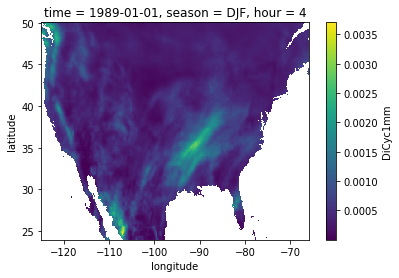

In [34]:
combined_ds.DiCyc1mm[3,10,:,:,4].plot()

In [5]:
def NWH(data):
    wet_day_thresh = 0.1/1000
    nan_mask = np.isnan(data)
    binary_mask = np.where(nan_mask, 0, 1)
    numeric_indices = np.where(binary_mask == 1)[0]
    if len(numeric_indices) == 0:
        maxima_data = np.nan
    elif len(numeric_indices) == len(data):
        cwd = (data >= wet_day_thresh).sum()
        maxima_data = cwd
    elif len(numeric_indices) > 0 and len(numeric_indices) < len(data):
        nan_indices = np.where(binary_mask == 0)[0]
        data = data.copy()
        data[nan_indices] = 0
        cwd = (data >= wet_day_thresh).sum()
        maxima_data = cwd
    return maxima_data

In [55]:
combined_ds.DiCyc1mm[0,0,:,0,0]

<xarray.DataArray 'DiCyc1mm' (hour: 24)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
Coordinates:
    latitude   float32 50.0
    longitude  float32 -125.0
    time       datetime64[ns] 1979-01-01
    season     <U3 'MAM'
  * hour       (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23

In [5]:
# Currently calculating for one hour. 
# formula: total precipitation on wet hours in one month / count of wet hours

def SPIIHhr(data):
    wet_day_thresh = 0.1/1000
    nan_mask = np.isnan(data)
    binary_mask = np.where(nan_mask, 0, 1)
    numeric_indices = np.where(binary_mask == 1)[0]
    if len(numeric_indices) == 0:
        maxima_data = np.nan
    elif len(numeric_indices) == len(data):
        cwd = int((data >= wet_day_thresh).sum())
        if cwd != 0:
            tp_cwd = data[data >= wet_day_thresh].sum()
            maxima_data = tp_cwd/cwd
        else:
            maxima_data = 0
    elif len(numeric_indices) > 0 and len(numeric_indices) < len(data):
        nan_indices = np.where(binary_mask == 0)[0]
        data = data.copy()
        data[nan_indices] = 0
        cwd = int((data >= wet_day_thresh).sum())
        if cwd != 0:
            tp_cwd = data[data >= wet_day_thresh].sum()
            maxima_data = tp_cwd/cwd
        else:
            maxima_data = 0
    return maxima_data

In [5]:
def PRCPTOT1h(data):
    wet_hour_thresh =  0.1/1000
    nan_mask = np.isnan(data)
    binary_mask = np.where(nan_mask, 0, 1)
    numeric_indices = np.where(binary_mask == 1)[0]
    if len(numeric_indices) == 0:
        maxima_data = np.nan
    elif len(numeric_indices) == len(data):
        maxima_data = data[data >= wet_hour_thresh].sum()
    elif len(numeric_indices) > 0 and len(numeric_indices) < len(data):
        nan_indices = np.where(binary_mask == 0)[0]
        data = data.copy()
        data[nan_indices]=0
        maxima_data = data[data >= wet_hour_thresh].sum()
    return maxima_data

In [5]:
def Rx1h(data):
    nan_mask = np.isnan(data)
    binary_mask = np.where(nan_mask, 0, 1)
    numeric_indices = np.where(binary_mask == 1)[0]
    if len(numeric_indices)>0 and len(numeric_indices)==len(data):
        filtered_data = data[numeric_indices]
        maxima_data = filtered_data.max()
    elif len(numeric_indices)>0 and len(numeric_indices)<len(data):
        nan_indices = np.where(binary_mask == 0)[0]
        data = data.copy()
        data[nan_indices] = 0
        maxima_data = data.max()
    else:
        maxima_data = np.nan
    return maxima_data

In [5]:
def Rx3h(data):
    nan_mask = np.isnan(data)
    binary_mask = np.where(nan_mask, 0, 1)
    numeric_indices = np.where(binary_mask == 1)[0]
    if len(numeric_indices) == 0:
        maxima_data = np.nan
    elif len(numeric_indices) == len(data):
        resample_data = data.reshape(int(len(data)/3), 3)
        maxima_data = np.sum(resample_data, axis=1).max()
    elif len(numeric_indices) > 0 and len(numeric_indices) < len(data):
        nan_indices = np.where(binary_mask == 0)[0]
        data = data.copy()
        data[nan_indices]=0
        resample_data = data.reshape(int(len(data)/3), 3)
        maxima_data = np.sum(resample_data, axis=1).max()
    return maxima_data

In [5]:
def Rx6h(data):
    nan_mask = np.isnan(data)
    binary_mask = np.where(nan_mask, 0, 1)
    numeric_indices = np.where(binary_mask == 1)[0]
    if len(numeric_indices) == 0:
        maxima_data = np.nan
    elif len(numeric_indices) == len(data):
        resample_data = data.reshape(int(len(data)/6), 6)
        maxima_data = np.sum(resample_data, axis=1).max()
    elif len(numeric_indices) > 0 and len(numeric_indices) < len(data):
        nan_indices = np.where(binary_mask == 0)[0]
        data = data.copy()
        data[nan_indices]=0
        resample_data = data.reshape(int(len(data)/6), 6)
        maxima_data = np.sum(resample_data, axis=1).max()
#     print(maxima_data)
    return maxima_data

In [5]:
def Rx12h(data):
    nan_mask = np.isnan(data)
    binary_mask = np.where(nan_mask, 0, 1)
    numeric_indices = np.where(binary_mask == 1)[0]
    if len(numeric_indices) == 0:
        maxima_data = np.nan
    elif len(numeric_indices) == len(data):
        resample_data = data.reshape(int(len(data)/12), 12)
        maxima_data = np.sum(resample_data, axis=1).max()
    elif len(numeric_indices) > 0 and len(numeric_indices) < len(data):
        nan_indices = np.where(binary_mask == 0)[0]
        data = data.copy()
        data[nan_indices]=0
        resample_data = data.reshape(int(len(data)/12), 12)
        maxima_data = np.sum(resample_data, axis=1).max()
#     print(maxima_data)
    return maxima_data

In [6]:
def R10mm1h(data):
    thresh_m = 10/1000 # convert mm to meter
    nan_mask = np.isnan(data)
    binary_mask = np.where(nan_mask, 0, 1)
    numeric_indices = np.where(binary_mask == 1)[0]
    if len(numeric_indices) == 0:
        maxima_data = np.nan
    elif len(numeric_indices) == len(data):
        maxima_data = (data>=thresh_m).sum()
    elif len(numeric_indices) > 0 and len(numeric_indices) < len(data):
        nan_indices = np.where(binary_mask == 0)[0]
        data = data.copy()
        data[nan_indices]=0
        maxima_data = (data>=thresh_m).sum()
    return maxima_data

In [5]:
def R20mm1h(data):
    thresh_m = 20/1000 # convert mm to meter
    nan_mask = np.isnan(data)
    binary_mask = np.where(nan_mask, 0, 1)
    numeric_indices = np.where(binary_mask == 1)[0]
    if len(numeric_indices) == 0:
        maxima_data = np.nan
    elif len(numeric_indices) == len(data):
        maxima_data = (data>=thresh_m).sum()
    elif len(numeric_indices) > 0 and len(numeric_indices) < len(data):
        nan_indices = np.where(binary_mask == 0)[0]
        data = data.copy()
        data[nan_indices]=0
        maxima_data = (data>=thresh_m).sum()
    return maxima_data

In [5]:
def MxLWS(data):
    wet_day_thresh = 0.1/1000
    nan_mask = np.isnan(data)
    binary_mask = np.where(nan_mask, 0, 1)
    numeric_indices = np.where(binary_mask == 1)[0]
    if len(numeric_indices) == 0:
        maxima_data = np.nan
    elif len(numeric_indices) == len(data):
        wet_data = data >= wet_day_thresh
        wet_spells =  [len(list(group)) for key, group in groupby(wet_data, key=lambda x: x != False) if key]
        if len(wet_spells) != 0:  
            maxima_data = max(wet_spells)
        else:
            maxima_data = 0
    elif len(numeric_indices) > 0 and len(numeric_indices) < len(data):
        nan_indices = np.where(binary_mask == 0)[0]
        data = data.copy()
        data[nan_indices] = 0
        wet_data = data >= wet_day_thresh
        wet_spells = [len(list(group)) for key, group in groupby(tf, key=lambda x: x != False) if key]
        if len(wet_spells) != 0:  
            maxima_data = max(wet_spells)
        else:
            maxima_data = 0
    
    return maxima_data

In [5]:
def MeLWS(data):
    wet_day_thresh = 0.1/1000
    nan_mask = np.isnan(data)
    binary_mask = np.where(nan_mask, 0, 1)
    numeric_indices = np.where(binary_mask == 1)[0]
    if len(numeric_indices) == 0:
        maxima_data = np.nan
    elif len(numeric_indices) == len(data):
        wet_data = data >= wet_day_thresh
        wet_spells = [len(list(group)) for key, group in groupby(wet_data, key=lambda x: x != False) if key]
        if len(wet_spells) != 0:  
            maxima_data = np.mean(wet_spells)
        else:
            maxima_data = 0
    elif len(numeric_indices) > 0 and len(numeric_indices) < len(data):
        nan_indices = np.where(binary_mask == 0)[0]
        data = data.copy()
        data[nan_indices] = 0
        wet_data = data >= wet_day_thresh
        wet_spells = [len(list(group)) for key, group in groupby(wet_data, key=lambda x: x != False) if key]
        if len(wet_spells) != 0:  
            maxima_data = np.mean(wet_spells)
        else:
            maxima_data = 0
    
    return maxima_data

In [5]:
def RQpwHhrPj_99(data):
    wet_day_thresh = 0.1/1000
    nan_mask = np.isnan(data)
    binary_mask = np.where(nan_mask, 0, 1)
    numeric_indices = np.where(binary_mask == 1)[0]
    if len(numeric_indices) == 0:
        maxima_data = np.nan
    elif len(numeric_indices) == len(data):
        wet_hour_data = data[data >= wet_day_thresh]
        rtot = wet_hour_data.sum()
        if rtot > 0:
            percent_99_thresh = np.percentile(wet_hour_data, 99)
            maxima_data = (wet_hour_data[wet_hour_data >= percent_99_thresh].sum() / rtot) * 100
        else:
            maxima_data = 0
    elif len(numeric_indices) > 0 and len(numeric_indices) < len(data):
        nan_indices = np.where(binary_mask == 0)[0]
        data = data.copy()
        data[nan_indices] = 0  
        wet_hour_data = data[data >= wet_day_thresh]
        rtot = wet_hour_data.sum()
        if rtot > 0:
            percent_99_thresh = np.percentile(wet_hour_data, 99)
            maxima_data = (wet_hour_data[wet_hour_data >= percent_99_thresh].sum() / rtot) * 100
        else:
            maxima_data = 0
    return maxima_data

In [5]:
def RQpwHhrPj_95(data):
    wet_day_thresh = 0.1/1000
    nan_mask = np.isnan(data)
    binary_mask = np.where(nan_mask, 0, 1)
    numeric_indices = np.where(binary_mask == 1)[0]
    if len(numeric_indices) == 0:
        maxima_data = np.nan
    elif len(numeric_indices) == len(data):
        wet_hour_data = data[data >= wet_day_thresh]
        rtot = wet_hour_data.sum()
        if rtot > 0:
            percent_95_thresh = np.percentile(wet_hour_data, 95)
            maxima_data = (wet_hour_data[wet_hour_data >= percent_95_thresh].sum() / rtot) * 100
        else:
            maxima_data = 0
    elif len(numeric_indices) > 0 and len(numeric_indices) < len(data):
        nan_indices = np.where(binary_mask == 0)[0]
        data = data.copy()
        data[nan_indices] = 0  
        wet_hour_data = data[data >= wet_day_thresh]
        rtot = wet_hour_data.sum()
        if rtot > 0:
            percent_95_thresh = np.percentile(wet_hour_data, 95)
            maxima_data = (wet_hour_data[wet_hour_data >= percent_95_thresh].sum() / rtot) * 100
        else:
            maxima_data = 0
    return maxima_data

In [6]:
def Rx1hP(data, time):
    nan_mask = np.isnan(data)
    binary_mask = np.where(nan_mask, 0, 1)
    numeric_indices = np.where(binary_mask == 1)[0]
    
    if len(numeric_indices)==len(data):
        filtered_data = data[numeric_indices]
        max_val_ind, max_val = np.argmax(filtered_data), max(filtered_data)
        indexes = np.where(time.astype('datetime64[D]') == np.datetime64(time[max_val_ind], 'D'))[0]
        max_day_sum = filtered_data[indexes].sum()
        maxima_data = (max_val/max_day_sum)*100
        
    elif len(numeric_indices)>0 and len(numeric_indices)<len(data):
        nan_indices = np.where(binary_mask == 0)[0]
        data = data.copy()
        data[nan_indices] = 0
        max_val_ind, max_val = np.argmax(data), max(data)
        indexes = np.where(time.astype('datetime64[D]') == np.datetime64(time[max_val_ind], 'D'))[0]
        max_day_sum = data[indexes].sum()
        maxima_data = (max_number/max_day_sum)*100
        
    else:
        maxima_data = np.nan
    
    return maxima_data            

In [35]:
# seasons = {'MAM':[3, 4, 5]}
# for season, months in seasons.items():
#     print("Season : ", season)
#     selected_data = combined_data.sel(time=combined_data['time.month'].isin(months))

In [31]:
# def calc_ind(data,indice):
# #     tim_arr = []
#     ind_arr = []
#     seasons = {'MAM':[3, 4, 5], 'JJA':[6, 7, 8], 'SON':[9, 10, 11], 'DJF':[12, 1, 2]}
#     for season, months in seasons.items():
#         print("Season : ", season)
#         selected_data = data.sel(time=data['time.month'].isin(months))
#         result_indice = xr.apply_ufunc(indice, selected_data, input_core_dims=[['time']],
#         dask='parallelized',
#         output_dtypes=[float],
#         vectorize=True)
#         ind_arr.append(result_indice)
#         print(ind_arr)
# #         ind_arr.append(result_indice)
#     return ind_arr

In [8]:
# def calc_ind_Rx1hP(data,indice, year):
# #     tim_arr = []
#     ind_arr = []
#     seasons = {'MAM':[3, 4, 5], 'JJA':[6, 7, 8], 'SON':[9, 10, 11], 'DJF':[12, 1, 2]}
#     for season, months in seasons.items():
#         print("Season : ", season)
#         if season == 'MAM':
#             start_month = months[0]
#             end_month = months[2]
#             dates = date_range(year,start_month,end_month)
#             selected_data = data.sel(time=data['time.month'].isin(months))
#             result_indice = xr.apply_ufunc(indice, selected_data, kwargs={'time': dates}, 
#                                             input_core_dims=[['time']],
#                                             dask='parallelized',
#                                             output_dtypes=[float],
#                                             vectorize=True)
#             ind_arr.append(result_indice)
#             print("MAM ", result_indice)
#         elif season == 'JJA':
#             start_month = months[0]
#             end_month = months[2]
#             dates = date_range(year,start_month,end_month)
#             selected_data = data.sel(time=data['time.month'].isin(months))
#             result_indice = xr.apply_ufunc(indice, selected_data, kwargs={'time': dates}, 
#                                             input_core_dims=[['time']],
#                                             dask='parallelized',
#                                             output_dtypes=[float],
#                                             vectorize=True)
#             ind_arr.append(result_indice)
#             print("JJA ", result_indice)
#         elif season == 'SON':
#             start_month = months[0]
#             end_month = months[2]
#             dates = date_range(year,start_month,end_month)
#             selected_data = data.sel(time=data['time.month'].isin(months))
#             result_indice = xr.apply_ufunc(indice, selected_data, kwargs={'time': dates}, 
#                                             input_core_dims=[['time']],
#                                             dask='parallelized',
#                                             output_dtypes=[float],
#                                             vectorize=True)
#             ind_arr.append(result_indice)
#             print("SON ", result_indice)
#         elif season == 'DJF':
#             start_month = months[0]
#             end_month = months[2]
#             dates = date_range(year,start_month,end_month)
#             selected_data = data.sel(time=data['time.month'].isin(months)).sortby("time")
# #             print(dates, '\n', selected_data)
#             result_indice = xr.apply_ufunc(indice, selected_data, kwargs={'time': dates}, 
#                                             input_core_dims=[['time']],
#                                             dask='parallelized',
#                                             output_dtypes=[float],
#                                             vectorize=True)
#             ind_arr.append(result_indice)
#             print("DJF ", result_indice)
#     return ind_arr

In [7]:
def store_ind_date(data, year):
#     tim_arr = []
    ind_arr = []
    seasons = {'MAM':[3, 4, 5]}
#     , 'JJA':[6, 7, 8], 'SON':[9, 10, 11], 'DJF':[12, 1, 2]}
    for season, months in seasons.items():
        print("Season : ", season)
        if season == 'MAM':
            start_month = months[0]
            end_month = months[2]
            dates = date_range(year,start_month,end_month)
            selected_data = data.sel(time=data['time.month'].isin(months))
            result_indice = select_max_date(selected_data, dates)
            ind_arr.append(result_indice)
#             print("MAM ", result_indice)
        elif season == 'JJA':
            start_month = months[0]
            end_month = months[2]
            dates = date_range(year,start_month,end_month)
            selected_data = data.sel(time=data['time.month'].isin(months))
            result_indice = select_max_date(selected_data, dates)
            ind_arr.append(result_indice)
#             print("JJA ", result_indice)
        elif season == 'SON':
            start_month = months[0]
            end_month = months[2]
            dates = date_range(year,start_month,end_month)
            selected_data = data.sel(time=data['time.month'].isin(months))
            result_indice = select_max_date(selected_data, dates)
            ind_arr.append(result_indice)
#             print("SON ", result_indice)
        elif season == 'DJF':
            start_month = months[0]
            end_month = months[2]
            dates = date_range(year,start_month,end_month)
            selected_data = data.sel(time=data['time.month'].isin(months)).sortby("time")
            result_indice = select_max_date(selected_data, dates)
            ind_arr.append(result_indice)
#             print("DJF ", result_indice)
    return ind_arr

In [8]:
MAM_data = []
JJA_data = []
SON_data = []
DJF_data = []
for year in range(1979,1980):
    yearly_data = []
    for month in range(1, 12):
        ds = read_data(curr_data_path, month, year)
        if 'expver' in ds.dims:
            ds = ds.sel(expver=1).combine_first(ds.sel(expver=5))
            yearly_data.append(ds)
        else:
            yearly_data.append(ds)
    yearly_data.append(read_data(curr_data_path, 12, year-1))
    combined_data = xr.concat(yearly_data, dim="time")
    result = store_ind_date(combined_data, year) # Add Index function name
    MAM_data.append(result[0])
    JJA_data.append(result[1])
    SON_data.append(result[2])
    DJF_data.append(result[3])
    print(year)
#     combined_data.to_netcdf(f"../yearly_data/{year}_data.nc")

Season :  MAM
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260


IndexError: list index out of range

In [39]:
#modify Rx1h
rx1h = xr.open_dataset('../indices/seasonal/Rx1h_tp_1979_2023.nc')

In [8]:
tim_arr = np.arange('1979','2024',dtype='datetime64[Y]')

In [11]:
season_list = ['MAM', 'JJA', 'SON', 'DJF']
season = xr.DataArray(season_list, dims='season', coords={'season': season_list})
latitude = xr.DataArray(MAM_data[0]['latitude'].data, dims='latitude', coords={'latitude': MAM_data[0]['latitude'].data})
longitude = xr.DataArray(MAM_data[0]['longitude'].data, dims='longitude', coords={'longitude': MAM_data[0]['longitude'].data})
time = xr.DataArray(tim_arr, dims='time', coords={'time': tim_arr})

combined_ds = xr.Dataset(coords={'latitude': latitude, 'longitude': longitude, 'time': time, 'season': season})

combined_ds['Rx1hP'] = (('season',  'time','latitude', 'longitude'), np.nan * np.ones((len(season), len(time), len(latitude), len(longitude))))

/tmp/ipykernel_1775167/1197094348.py:5: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  time = xr.DataArray(tim_arr, dims='time', coords={'time': tim_arr})
/tmp/ipykernel_1775167/1197094348.py:5: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by con

In [12]:
def retrieve_data(season_val):
    data_values = []
    for data in season_val:
        data_values.append(data.tp.data)
    return data_values

In [14]:
combined_ds.Rx1hP[0,:,:,:] = retrieve_data(MAM_data)
combined_ds.Rx1hP[1,:,:,:] = retrieve_data(JJA_data)
combined_ds.Rx1hP[2,:,:,:] = retrieve_data(SON_data)
combined_ds.Rx1hP[3,:,:,:] = retrieve_data(DJF_data)

In [15]:
save_indice('Rx1hP_tp_1979_2023', combined_ds)

Rx1hP_tp_1979_2023_File Saved


In [17]:
combined_ds.Rx1hP[0,:,0,250]

<xarray.DataArray 'Rx1hP' (time: 45)>
array([38.22446167, 97.60881662, 25.86768866,  5.93382195,  7.940007  ,
        7.14096427,  5.53210527, 27.78205872, 23.56310636, 19.20452416,
       53.97203565, 44.12823021, 23.65159392,  6.50220662, 47.86185622,
       16.39299691, 94.53762174,  7.68547952, 99.99877214, 56.07915521,
       11.60207093, 79.22794819, 13.18038553,  5.08376695, 43.28303337,
       11.71924323, 95.20403743, 60.55978537, 17.8135097 , 13.14933002,
       15.25209993, 25.07141531, 10.32121778, 31.39894605,  5.98232523,
       23.23049456, 13.84190023,  9.87411067, 55.54863811, 28.66842151,
        5.83536252, 48.17272425,  7.71390796, 26.97227299, 11.8208006 ])
Coordinates:
    latitude   float32 50.0
    longitude  float32 -100.0
  * time       (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2023-01-01
    season     <U3 'MAM'

In [1]:
yearly_data

NameError: name 'yearly_data' is not defined

In [96]:
test = xr.open_dataset('../indices/monthly/Rx1hP_tp_1979_2023.nc')
test['time'] = pd.to_datetime(test['time'])

In [108]:
# 
for yr in range(1979,2024):
    sub = test.sel(time=test["time.year"].isin([yr]))
    sub_t = sub.sel(time=sub["time.month"].isin([12,1,2]))
    print(sub_t.Rx1hP[:,0,25].max().data)

70.49442529678345
56.89758658409119
50.21834373474121
72.96022176742554
40.15246629714966
69.07632350921631
23.59750270843506
71.0014820098877
25.518295168876648
90.98196029663086
70.2750027179718
79.86156940460205
54.82831597328186
16.413985192775726
98.82140755653381
74.78839755058289
58.02117586135864
40.533825755119324
19.728000462055206
66.3788378238678
47.269538044929504
78.69047522544861
79.09883260726929
33.46647918224335
34.27078425884247
89.00964856147766
55.26956915855408
49.75992441177368
37.385016679763794
49.40737187862396
38.29461634159088
97.75910973548889
68.8384473323822
12.615452706813812
58.04852843284607
40.847691893577576
34.30283963680267
54.44490909576416
11.854470521211624
35.623690485954285
18.389301002025604
94.58752870559692
22.313377261161804
45.060354471206665
46.79110944271088


In [79]:
MAM_data[0].tp[0,250]

<xarray.DataArray 'tp' ()>
array(38.22446167)
Coordinates:
    longitude  float32 -100.0
    latitude   float32 50.0

In [98]:
sub = combined_data.sel(time=combined_data['time.month'].isin([12,1,2])).sortby("time")

In [106]:
sub.tp[:,0,25].max().data

array(0.06051641, dtype=float32)

In [100]:
np.argmax(sub.tp[:,0,25].data)

1800

In [104]:
sub.tp[:,0,25].time[1800]

<xarray.DataArray 'time' ()>
array('1979-02-14T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    longitude  float32 -122.5
    latitude   float32 50.0
    time       datetime64[ns] 1979-02-14
Attributes:
    long_name:  time

In [105]:
sub.tp[:,0,25].sel(time="1979-02-14").sum()

<xarray.DataArray 'tp' ()>
array(0.08584566, dtype=float32)
Coordinates:
    longitude  float32 -122.5
    latitude   float32 50.0

In [107]:
(0.06051641*100)/0.08584566

70.49443151814548